## _*H2 ground state energy computation using Iterative QPE*_

This notebook demonstrates using Qiskit Chemistry to plot graphs of the ground state energy of the Hydrogen (H2) molecule over a range of inter-atomic distances using IQPE (Iterative Quantum Phase Estimation) algorithm. It is compared to the same energies as computed by the ExactEigensolver

This notebook populates a dictionary, that is a progammatic representation of an input file, in order to drive the qiskit_chemistry stack. Such a dictionary can be manipulated programmatically and this is indeed the case here where we alter the molecule supplied to the driver in each loop.

This notebook has been written to use the PYSCF chemistry driver. See the PYSCF chemistry driver readme if you need to install the external PySCF library that this driver requires.

In [1]:
import numpy as np
import pylab
from qiskit import LegacySimulators
from qiskit_chemistry import QiskitChemistry
import time

# Input dictionary to configure Qiskit Chemistry for the chemistry problem.
qiskit_chemistry_dict = {
    'driver': {'name': 'PYSCF'},
    'PYSCF': {'atom': '', 'basis': 'sto3g'},
    'operator': {'name': 'hamiltonian', 'transformation': 'full', 'qubit_mapping': 'parity'},
    'algorithm': {'name': ''},
    'initial_state': {'name': 'HartreeFock'},
}
molecule = 'H .0 .0 -{0}; H .0 .0 {0}'
algorithms = [
    {
        'name': 'IQPE',
        'num_iterations': 16,
        'num_time_slices': 3000,
        'expansion_mode': 'trotter',
        'expansion_order': 1,
    },
    {
        'name': 'ExactEigensolver'
    }
]

backends = [
    LegacySimulators.get_backend('qasm_simulator'),
    None
]

start = 0.5  # Start distance
by    = 0.5  # How much to increase distance by
steps = 20   # Number of steps to increase by
energies = np.empty([len(algorithms), steps+1])
hf_energies = np.empty(steps+1)
distances = np.empty(steps+1)

In [2]:
import concurrent.futures
import multiprocessing as mp
import copy

def subrountine(i, qiskit_chemistry_dict, d, backend, algorithm):
    solver = QiskitChemistry()
    qiskit_chemistry_dict['PYSCF']['atom'] = molecule.format(d/2) 
    qiskit_chemistry_dict['algorithm'] = algorithm
    result = solver.run(qiskit_chemistry_dict, backend=backend)
    return i, d, result['energy'], result['hf_energy']

In [3]:
start_time = time.time()
max_workers = max(4, mp.cpu_count())
with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    futures = []
    for j in range(len(algorithms)):
        algorithm = algorithms[j]
        backend = backends[j]
        for i in range(steps+1):
            d = start + i*by/steps
            future = executor.submit(
                subrountine, 
                i, 
                copy.deepcopy(qiskit_chemistry_dict), 
                d, 
                backend, 
                algorithm
            )
            futures.append(future)
        for future in concurrent.futures.as_completed(futures):
            i, d, energy, hf_energy = future.result()
            energies[j][i] = energy
            hf_energies[i] = hf_energy
            distances[i] = d
        
print(' --- complete')

print('Distances: ', distances)
print('Energies:', energies)
print('Hartree-Fock energies:', hf_energies)

print("--- %s seconds ---" % (time.time() - start_time))

 --- complete
Distances:  [0.5   0.525 0.55  0.575 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775
 0.8   0.825 0.85  0.875 0.9   0.925 0.95  0.975 1.   ]
Energies: [[-1.05394029 -1.07537168 -1.09193522 -1.10534368 -1.11548918 -1.1232653
  -1.12869848 -1.13338114 -1.13493551 -1.13632972 -1.1364747  -1.13529234
  -1.13323618 -1.13012864 -1.12773585 -1.12335899 -1.11914159 -1.11450112
  -1.10994671 -1.10478822 -1.09957597]
 [-1.05515979 -1.07591366 -1.09262991 -1.10591805 -1.11628601 -1.12416092
  -1.12990478 -1.13382622 -1.13618945 -1.13722138 -1.13711707 -1.13604436
  -1.13414767 -1.13155121 -1.12836188 -1.12467175 -1.12056028 -1.11609624
  -1.11133942 -1.10634211 -1.10115033]]
Hartree-Fock energies: [-1.04299627 -1.06306214 -1.07905074 -1.0915705  -1.10112824 -1.10814999
 -1.11299655 -1.11597526 -1.11734903 -1.11734327 -1.11615145 -1.11393966
 -1.1108504  -1.10700581 -1.10251055 -1.09745432 -1.09191404 -1.08595587
 -1.07963693 -1.07300676 -1.06610865]
--- 517.6182761192322 seconds ---

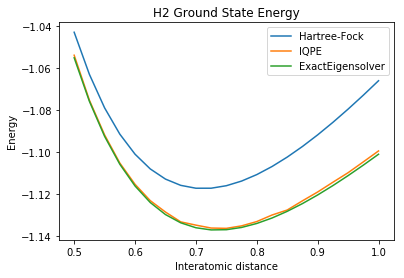

In [4]:
pylab.plot(distances, hf_energies, label='Hartree-Fock')
for j in range(len(algorithms)):
    pylab.plot(distances, energies[j], label=algorithms[j]['name'])
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('H2 Ground State Energy')
pylab.legend(loc='upper right')
pylab.show()

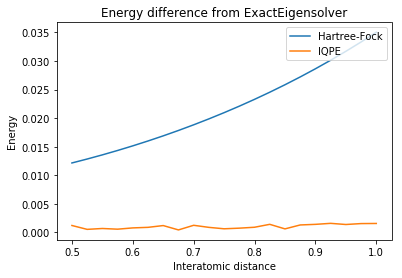

In [5]:
pylab.plot(distances, np.subtract(hf_energies, energies[1]), label='Hartree-Fock')
pylab.plot(distances, np.subtract(energies[0], energies[1]), label='IQPE')
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('Energy difference from ExactEigensolver')
pylab.legend(loc='upper right')
pylab.show()